# Import packages, define helper function

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask.array as da
import gcsfs
import os

import deepsensor.torch
from deepsensor.data import DataProcessor, TaskLoader, construct_circ_time_ds
from deepsensor.data.sources import get_era5_reanalysis_data, get_earthenv_auxiliary_data, \
    get_gldas_land_mask
from deepsensor.model import ConvNP
from deepsensor.train import Trainer, set_gpu_default_device

In [2]:
deepsensor_folder = '/deepsensor-greatlakes/saved_models'

In [3]:
set_gpu_default_device()

In [4]:
def standardize_dates(ds):
    """
    Convert the 'time' dimension in an xarray dataset to date-only precision with datetime64[D].
    
    Parameters:
    ds (xarray.Dataset): The dataset whose 'time' dimension you wish to modify.
    
    Returns:
    xarray.Dataset: Modified dataset with time as datetime64[D].
    """
    if 'time' in ds.coords:
        # Convert time to day-level precision
        ds['time'] = ds['time'].dt.floor('D').values.astype('datetime64[D]')
    
    return ds

### Inputs

In [5]:
# Training/data config (adapted for Great Lakes)
data_range = ("2009-01-01", "2022-12-31")
train_range = ("2009-01-01", "2021-12-31")
val_range = ("2022-01-01", "2022-12-31")
date_subsample_factor = 10
extent = "great_lakes"
#cache_dir = "../../.datacache"
#deepsensor_folder = "../deepsensor_config/"

# Data Inventory and Preprocessing

### Temporal datasets: SST, ice concentration

In [6]:
# Path to your Zarr stores
ice_concentration_path = 'gs://great-lakes-osd/ice_concentration.zarr'
glsea_path = 'gs://great-lakes-osd/GLSEA_combined.zarr'
glsea3_path = 'gs://great-lakes-osd/GLSEA3_combined.zarr'

# Open the Zarr stores
ice_concentration_raw = xr.open_zarr(ice_concentration_path, chunks={'time': 366, 'lat': 200, 'lon': 200})
glsea_raw = xr.open_zarr(glsea_path, chunks={'time': 366, 'lat': 200, 'lon': 200})
glsea3_raw = xr.open_zarr(glsea3_path, chunks={'time': 366, 'lat': 200, 'lon': 200})

# Replace -1 (land value) with NaN
ice_concentration_raw = ice_concentration_raw.where(ice_concentration_raw != -1, float('nan'))

# Convert all times to date-only format, removing the time component
ice_concentration_raw = standardize_dates(ice_concentration_raw)
glsea_raw = standardize_dates(glsea_raw)
glsea3_raw = standardize_dates(glsea3_raw)

# Drop CRS - not needed
glsea_raw = glsea_raw.drop_vars('crs')
glsea3_raw = glsea3_raw.drop_vars('crs')

### Static datasets: lake mask, bathymetry

In [7]:
# Set up GCS filesystem
fs = gcsfs.GCSFileSystem(project='your-gcp-project')

# Path to the NetCDF files 
context_path = 'gs://great-lakes-osd/context/'

# Open the NetCDF files using xarray with gcsfs
bathymetry_raw = xr.open_dataset(fs.open(os.path.join(context_path, 'interpolated_bathymetry.nc')))
lakemask_raw = xr.open_dataset(fs.open(os.path.join(context_path, 'lakemask.nc')))

# Name the bathymetry variable
bathymetry_raw = bathymetry_raw.rename({'__xarray_dataarray_variable__': 'bathymetry'})

# Data Processor

In [8]:
data_processor = DataProcessor(x1_name="lat", x2_name="lon")
print(data_processor)

DataProcessor with normalisation params:
{'coords': {'time': {'name': 'time'},
            'x1': {'map': None, 'name': 'lat'},
            'x2': {'map': None, 'name': 'lon'}}}


In [9]:
#glsea = data_processor(glsea_raw)
_ = data_processor(glsea_raw.sel(time=slice("2009-01-01", "2009-12-31")))
glsea = data_processor(glsea_raw)

# process the bathymetry and lake
aux_ds, lakemask = data_processor([bathymetry_raw, lakemask_raw], method="min_max")

In [10]:
# Select a subset of the ice concentration data to compute normalization parameters
#_ = data_processor(ice_concentration_raw.sel(time=slice("2009-01-01", "2009-12-31")))

# Now apply the normalization parameters to the full ice concentration dataset
#ice_concentration = data_processor(ice_concentration_raw, method="min_max")

In [11]:
data_processor.config

{'coords': {'time': {'name': 'time'},
  'x1': {'name': 'lat', 'map': (38.8749871947229, 55.4132976408956)},
  'x2': {'name': 'lon', 'map': (-92.4199507342304, -75.8816402880577)}},
 'sst': {'method': 'mean_std',
  'params': {'mean': 7.873531818389893, 'std': 6.944828510284424}},
 'bathymetry': {'method': 'min_max',
  'params': {'min': 9.999999999999998, 'max': 316.62872313037894}},
 'mask': {'method': 'min_max', 'params': {'min': 0.0, 'max': 1.0}}}

In [12]:
dates = pd.date_range(glsea_raw.time.values.min(), glsea_raw.time.values.max(), freq="D")
dates = pd.to_datetime(dates).normalize()  # This will set all times to 00:00:00

In [13]:
doy_ds = construct_circ_time_ds(dates, freq="D")
aux_ds["cos_D"] = standardize_dates(doy_ds["cos_D"])
aux_ds["sin_D"] = standardize_dates(doy_ds["sin_D"])
aux_ds

<xarray.Dataset> Size: 941kB
Dimensions:     (x1: 240, x2: 360, time: 10227)
Coordinates:
  * x1          (x1) float64 2kB 0.1523 0.1542 0.1561 ... 0.5958 0.5976 0.5995
  * x2          (x2) float64 3kB 0.02107 0.02375 0.02642 ... 0.9791 0.9818
  * time        (time) datetime64[s] 82kB 1995-01-01 1995-01-02 ... 2022-12-31
Data variables:
    bathymetry  (x1, x2) float64 691kB nan nan nan nan nan ... nan nan nan nan
    cos_D       (time) float64 82kB 0.9999 0.9994 0.9987 ... 0.9993 0.9998 1.0
    sin_D       (time) float64 82kB 0.0172 0.0344 0.05158 ... -0.0215 -0.004301

# Tasks

## Generating random coordinates from inside the mask

In [14]:
def generate_random_coordinates(mask_da, N, data_processor=None):
    """
    Generate N random coordinates (lat, lon) from a mask with values 1 inside the lake area,
    and normalize them using the DataProcessor if provided.
    
    Parameters:
    mask_da: xarray DataArray containing the mask (with 1 for valid, 0 for invalid areas)
    N: Number of random points to generate
    data_processor: (optional) DataProcessor object for normalization if needed
    
    Returns:
    numpy.ndarray: Array of shape (2, N) with random latitudes and longitudes from the masked region
    """
    
    # Get the valid indices where the mask is 1
    mask = mask_da['mask'].values
    valid_indices = np.argwhere(mask == 1)
    
    # Randomly sample N points from the valid indices
    random_indices = valid_indices[np.random.choice(valid_indices.shape[0], N, replace=False)]
    
    # Get the latitude and longitude coordinates for the sampled indices
    latitudes = mask_da['lat'].values[random_indices[:, 0]]
    longitudes = mask_da['lon'].values[random_indices[:, 1]]
    
    # Create a dummy variable (e.g., zeros for now)
    dummy_variable = np.random.rand(N)
    
    # Create a Pandas DataFrame with latitudes, longitudes, and the dummy variable
    random_coords_df = pd.DataFrame({
        'lat': latitudes,
        'lon': longitudes,
        'dummy': dummy_variable
    })
    
    # Set the index to ['lat', 'lon'] to match what DataProcessor expects
    random_coords_df = random_coords_df.set_index(['lat', 'lon'])
    
    if data_processor:
        normalized_coords_df = data_processor(random_coords_df, method="min_max")
        return normalized_coords_df.index.to_frame(index=False).values.T
    else:
        return np.vstack((latitudes, longitudes))


In [15]:
# Example usage
N = 100  # Number of random points
random_lake_points = generate_random_coordinates(lakemask_raw, N, data_processor)

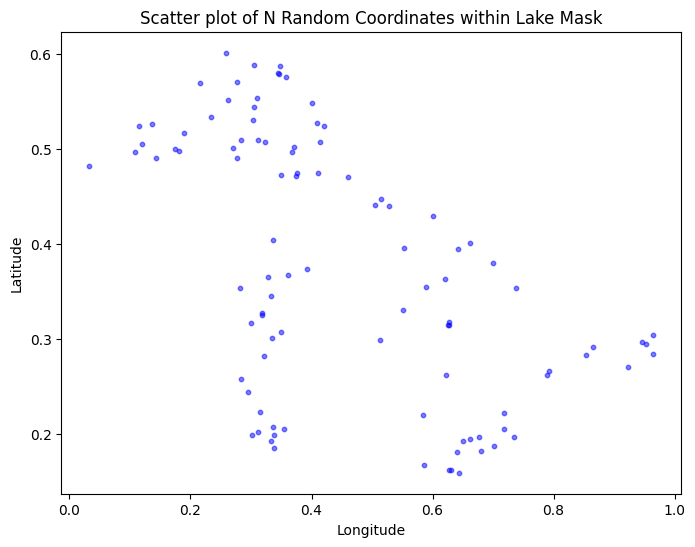

In [16]:
import matplotlib.pyplot as plt

# Assuming random_coords is the (2, N) array from the previous step
latitudes = random_lake_points[0, :]
longitudes = random_lake_points[1, :]

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(longitudes, latitudes, color='blue', alpha=0.5, s=10)
plt.title("Scatter plot of N Random Coordinates within Lake Mask")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [17]:
from deepsensor.data import TaskLoader
task_loader = TaskLoader(context=[glsea, aux_ds, lakemask], target=glsea)
#task_loader = TaskLoader(context=glsea, target=glsea)

# Model training

## Task generation

In [18]:
from tqdm import tqdm

# Define how Tasks are generated
def gen_tasks(dates, progress=True):
    tasks = []
    for date in tqdm(dates, disable=not progress):
        # Create task with context and target sampling
        task = task_loader(date, context_sampling=random_lake_points, target_sampling="all")
        
        # Remove NaNs from the target data (Y_t) in the task 
        # Target data cannot have NaNs
        task = task.remove_target_nans()
        
        # Append the processed task to the list
        tasks.append(task)
        
    return tasks

In [19]:
# Generate training and validation tasks
train_dates = pd.date_range(train_range[0], train_range[1])[::date_subsample_factor]
val_dates = pd.date_range(val_range[0], val_range[1])[::date_subsample_factor]

# Standardize the dates so they are datetime64[D] (date only, no time)
train_dates = pd.to_datetime(train_dates).normalize()  # This will set the time to 00:00:00
val_dates = pd.to_datetime(val_dates).normalize()      # This will set the time to 00:00:00

# Generate the tasks
train_tasks = gen_tasks(train_dates)
val_tasks = gen_tasks(val_dates)

100%|██████████| 37/37 [01:01<00:00,  1.67s/it]


In [20]:
train_tasks[30]

time: Timestamp/2009-10-28 00:00:00
ops: ['str/target_nans_removed']
X_c: ['ndarray/float32/(2, 100)', 'ndarray/float32/(2, 100)', 'ndarray/float32/(2, 100)']
Y_c: ['ndarray/float32/(1, 100)', 'ndarray/float32/(3, 100)', 'ndarray/float32/(1, 100)']
X_t: ['ndarray/float32/(2, 139599)']
Y_t: ['ndarray/float32/(1, 139599)']

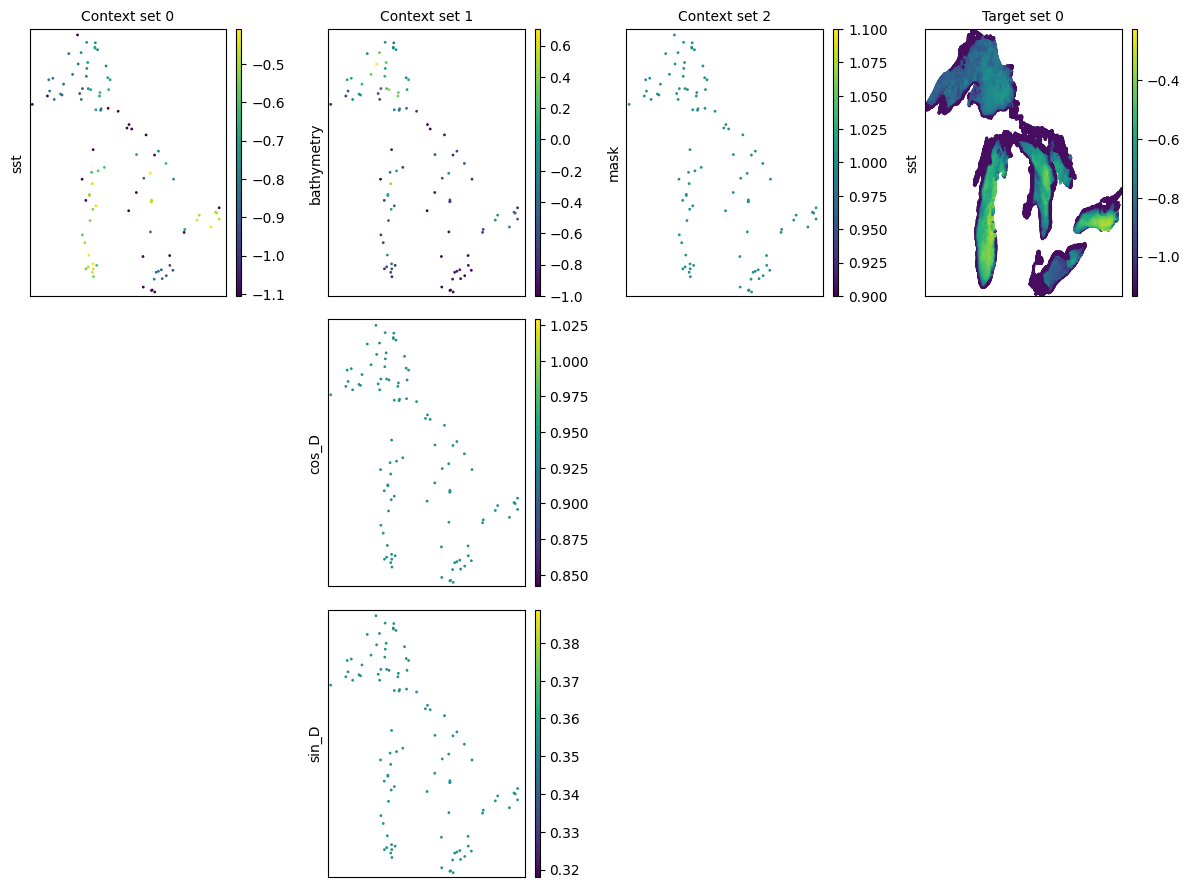

In [21]:
fig = deepsensor.plot.task(val_tasks[2], task_loader)
plt.show()

### Model set up

In [22]:
# Set up model
model = ConvNP(data_processor, task_loader)

dim_yc inferred from TaskLoader: (1, 3, 1)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 1180
encoder_scales inferred from TaskLoader: [np.float32(0.0004237288), np.float32(0.0009355429), np.float32(0.0004237288)]
decoder_scale inferred from TaskLoader: 0.000847457627118644


In [23]:
# Define the Trainer and training loop
trainer = Trainer(model, lr=5e-5)

In [24]:
# Monitor validation performance
def compute_val_rmse(model, val_tasks):
    errors = []
    target_var_ID = task_loader.target_var_IDs[0][0]  # assuming 1st target set and 1D
    for task in val_tasks:
        mean = data_processor.map_array(model.mean(task), target_var_ID, unnorm=True)
        true = data_processor.map_array(task["Y_t"][0], target_var_ID, unnorm=True)
        errors.extend(np.abs(mean - true))
    return np.sqrt(np.mean(np.concatenate(errors) ** 2))

In [ ]:
# Track the losses and validation RMSEs
losses = []
val_rmses = []
val_rmse_best = np.inf

# Start the training loop
for epoch in tqdm(range(50), desc="Training Epochs"):  # Training for 50 epochs
    # Generate tasks for training
    batch_losses = trainer(train_tasks)
    losses.append(np.mean(batch_losses))

    # Compute the validation RMSE
    val_rmse = compute_val_rmse(model, val_tasks)
    val_rmses.append(val_rmse)

    # Save the model if it performs better
    if val_rmse < val_rmse_best:
        val_rmse_best = val_rmse
        #model.save(deepsensor_folder)

# Plot training losses and validation RMSE
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(losses)
axes[0].set_xlabel('Epoch')
axes[0].set_title('Training Loss')

axes[1].plot(val_rmses)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Validation RMSE')

plt.show()


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]/home/jupyter/deepsensor-greatlakes/venv/lib/python3.10/site-packages/lab/types.py:178: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numerictypes.
  for name in np.core.numerictypes.__all__ + ["bool"]:
Training Epochs:   4%|▍         | 2/50 [45:03<18:01:31, 1351.91s/it]